# Compare alternative decision types on a value diagram

In [13]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [50]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

sys.path.append('..')
from ruv.relative_utility_value import relative_utility_value
from ruv.damage_functions import logistic_zero
from ruv.economic_models import cost_loss, cost_loss_analytical_spend
from ruv.utility_functions import cara
from ruv.decision_rules import optimise_over_forecast_distribution

# Load example forecast dataset

In [51]:
# Steamflow at Biggara in the Murray catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE and event frequency for reference

fcst = pd.read_csv('example_data/401012-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')

# group into weekly periods
set_periods = {
    'w1': (0, 7),
    'w2': (8, 14),
    'w3-4': (15, 30),
}

obs_sets = {}
fcst_sets = {}

for set, (start, end) in set_periods.items():
    curr = fcst[(fcst.index.day >= start) & (fcst.index.day <= end)]

    # fetch the obs and forecast ensemble
    curr_obs = curr['obs']
    curr_fcst = curr[[col for col in curr.columns if col.startswith('ens-')]]
    
    # RUV library expects numpy arrays
    obs_sets[set] = curr_obs.values
    fcst_sets[set] = curr_fcst.values

    print(set, obs_sets[set].shape, fcst_sets[set].shape)
    
ref = None     # RUV library will use obs to replicate event frequency reference as in REV

w1 (1932,) (1932, 100)
w2 (1932,) (1932, 100)
w3-4 (4376,) (4376, 100)


# Define decision context

In [52]:
alpha_step = 0.1
alphas = np.arange(alpha_step, 1, alpha_step)

decision_context = {
    'damage_function': [logistic_zero, {'A': 1, 'k': 0.07, 'threshold': 0.99}],  # this should be logistic
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_rule': [optimise_over_forecast_distribution, None],
}
# note there is no decision_thresholds defined, we will add this before calling relative_utility_value

# Calculate RUV using different decision rules

In [53]:
parallel_nodes = 8
results = xr.DataArray(np.nan, dims=('alpha', 'decision_type', 'week'), coords={'alpha': alphas, 'decision_type': ['binary', 'multicategorical', 'continuous'], 'week': list(set_periods.keys())})

In [54]:
for set in obs_sets.keys():
    print(f'Calculating RUV for set {set}')
    
    obs = obs_sets[set]
    fcst = fcst_sets[set]

    print('Binary')
    decision_context['decision_thresholds'] = np.insert([np.nanquantile(obs, 0.9)], 0, 0)
    results.loc[{'week': set, 'decision_type': 'binary'}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

    print('Multicategorical')
    decision_context['decision_thresholds'] = np.insert([np.nanquantile(obs, quant) for quant in [0.80, 0.85, 0.90, 0.95]], 0, 0)
    results.loc[{'week': set, 'decision_type': 'multicategorical'}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

    print('Continuous')
    decision_context['decision_thresholds'] = None
    results.loc[{'week': set, 'decision_type': 'continuous'}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']


Calculating RUV for set w1
Binary
Multicategorical
Continuous
Calculating RUV for set w2
Binary
Multicategorical
Continuous
Calculating RUV for set w3-4
Binary
Multicategorical
Continuous


# Plot results on a value diagram

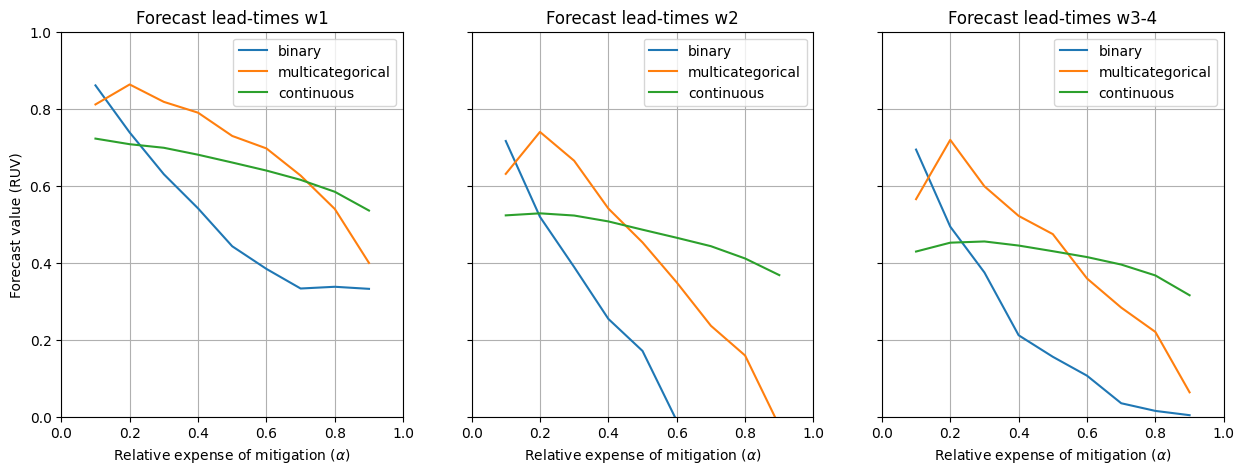

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

weeks = results.coords['week'].values
decision_types = results.coords['decision_type'].values

for i, week in enumerate(weeks):
    ax = axs[i]
    for decision_type in decision_types:
        data = results.sel(week=week, decision_type=decision_type)
        ax.plot(data.coords['alpha'].values, data.values, label=decision_type)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_title(f'Forecast lead-times {week}')
    ax.set_xlabel(r'Relative expense of mitigation ($\alpha$)')
    if i == 0:
        ax.set_ylabel('Forecast value (RUV)')

    ax.legend()
    ax.grid(True)
    

plt.show()